In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

In [2]:
train= pd.read_csv('train.csv')
test= pd.read_csv('test.csv')

In [3]:
X=train.drop(['label'],axis=1)
Y=train['label']
X=torch.from_numpy(np.array(X).reshape(-1,1,28,28)/255)
Y=torch.from_numpy(np.array(Y))
xtrain,xval,ytrain,yval=train_test_split(X,Y,test_size=0.2,random_state=2019)

train_batch_size=512
val_batch_size=512
train_dataset=torch.utils.data.TensorDataset(xtrain.type(torch.FloatTensor),ytrain.type(torch.LongTensor))
train_loader=torch.utils.data.DataLoader(train_dataset,batch_size=train_batch_size,shuffle=True)
val_dataset=torch.utils.data.TensorDataset(xval.type(torch.FloatTensor),yval.type(torch.LongTensor))
val_loader=torch.utils.data.DataLoader(val_dataset,batch_size=val_batch_size,shuffle=False)

In [4]:
class Flatten(nn.Module):
    def forward(self,input):
        return input.view(-1,64*3*3)
model=nn.Sequential(
    nn.Conv2d(1,16,3,padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(16,32,3,padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(32,64,3,padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(64*3*3,120),
    nn.ReLU(),
    nn.Linear(120,64),
    nn.ReLU(),
    nn.Linear(64,10)                    
)
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
def validation(model,dataload,criterion):
    running_loss = 0.0
    running_corrects = 0
    los=0
    for images,labels in dataload:
        #images=images.view(images.shape[0],784)
        images,labels=images.to(device),labels.to(device)
        output=model(images)

        test_loss=criterion(output,labels)
        los+=test_loss.item()
        preds = torch.argmax(output,1)
        running_loss += test_loss.item() * images.size(0)
        running_corrects += torch.sum(preds == labels)
    #print(output.shape)
    #epoch_loss = running_loss / len(xval)
    #print(type(running_loss))
    #print(epoch_loss),print(los/len(dataload))        
    epoch_loss = running_loss / len(xval)
    epoch_acc = running_corrects.double() / len(xval)
    
    print('{} Loss: {:.4f} Acc: {:.4f}'.format("valid", epoch_loss, epoch_acc))
    return epoch_acc,epoch_loss

In [6]:
#Learning_rate=0.001
loss_criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters())
epoch=210
var_loss=np.inf
train_losses,val_losses=[],[]
import time,copy
since = time.time()
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
model=model.to(device)
for e in range(epoch):
    running_loss = 0.0
    running_corrects = 0
    print('Epoch {}/{}:'.format(e+1, epoch))
    print('-' * 10)
    for images,labels in train_loader:
        images,labels=images.to(device),labels.to(device)
        optimizer.zero_grad()
        #images=images.view(images.shape[0],784)
        output=model(images)
        loss=loss_criterion(output,labels)
        preds = torch.argmax(output,1)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        running_corrects += torch.sum(preds == labels)
    epoch_loss = running_loss / len(xtrain)
    train_losses.append(epoch_loss)
    epoch_acc = running_corrects.double() / len(xtrain)
    print('{} Loss: {:.4f} Acc: {:.4f}'.format("Training", epoch_loss, epoch_acc))
    
    with torch.no_grad():
            model.eval()
            accuracy,epoch_loss=validation(model,val_loader,loss_criterion)
            val_losses.append(epoch_loss)
            if best_acc<accuracy:
                best_acc = accuracy
                torch.save(model.state_dict(),'model.pt')
            else:
                print("best acc is {:.4f}".format(best_acc))
    model.train()    
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
print('Best val Acc: {:4f}'.format(best_acc))
        

Epoch 1/210:
----------
Training Loss: 1.2609 Acc: 0.6014
valid Loss: 0.4575 Acc: 0.8392
Epoch 2/210:
----------
Training Loss: 0.2798 Acc: 0.9135
valid Loss: 0.1938 Acc: 0.9412
Epoch 3/210:
----------
Training Loss: 0.1718 Acc: 0.9471
valid Loss: 0.1425 Acc: 0.9557
Epoch 4/210:
----------
Training Loss: 0.1262 Acc: 0.9608
valid Loss: 0.1252 Acc: 0.9606
Epoch 5/210:
----------
Training Loss: 0.1029 Acc: 0.9677
valid Loss: 0.0945 Acc: 0.9679
Epoch 6/210:
----------
Training Loss: 0.0879 Acc: 0.9735
valid Loss: 0.0952 Acc: 0.9694
Epoch 7/210:
----------
Training Loss: 0.0751 Acc: 0.9771
valid Loss: 0.0740 Acc: 0.9746
Epoch 8/210:
----------
Training Loss: 0.0685 Acc: 0.9785
valid Loss: 0.0718 Acc: 0.9771
Epoch 9/210:
----------
Training Loss: 0.0590 Acc: 0.9818
valid Loss: 0.0623 Acc: 0.9805
Epoch 10/210:
----------
Training Loss: 0.0545 Acc: 0.9833
valid Loss: 0.0764 Acc: 0.9740
best acc is 0.9805
Epoch 11/210:
----------
Training Loss: 0.0505 Acc: 0.9841
valid Loss: 0.0608 Acc: 0.9796


Training Loss: 0.0000 Acc: 1.0000
valid Loss: 0.0564 Acc: 0.9890
best acc is 0.9902
Epoch 80/210:
----------
Training Loss: 0.0000 Acc: 1.0000
valid Loss: 0.0563 Acc: 0.9890
best acc is 0.9902
Epoch 81/210:
----------
Training Loss: 0.0000 Acc: 1.0000
valid Loss: 0.0579 Acc: 0.9889
best acc is 0.9902
Epoch 82/210:
----------
Training Loss: 0.0000 Acc: 1.0000
valid Loss: 0.0573 Acc: 0.9890
best acc is 0.9902
Epoch 83/210:
----------
Training Loss: 0.0000 Acc: 1.0000
valid Loss: 0.0580 Acc: 0.9892
best acc is 0.9902
Epoch 84/210:
----------
Training Loss: 0.0000 Acc: 1.0000
valid Loss: 0.0586 Acc: 0.9892
best acc is 0.9902
Epoch 85/210:
----------
Training Loss: 0.0000 Acc: 1.0000
valid Loss: 0.0588 Acc: 0.9894
best acc is 0.9902
Epoch 86/210:
----------
Training Loss: 0.0000 Acc: 1.0000
valid Loss: 0.0590 Acc: 0.9890
best acc is 0.9902
Epoch 87/210:
----------
Training Loss: 0.0000 Acc: 1.0000
valid Loss: 0.0592 Acc: 0.9890
best acc is 0.9902
Epoch 88/210:
----------
Training Loss: 0.00

Training Loss: 0.0000 Acc: 1.0000
valid Loss: 0.0759 Acc: 0.9889
best acc is 0.9902
Epoch 155/210:
----------
Training Loss: 0.0000 Acc: 1.0000
valid Loss: 0.0758 Acc: 0.9889
best acc is 0.9902
Epoch 156/210:
----------
Training Loss: 0.0000 Acc: 1.0000
valid Loss: 0.0758 Acc: 0.9888
best acc is 0.9902
Epoch 157/210:
----------
Training Loss: 0.0000 Acc: 1.0000
valid Loss: 0.0763 Acc: 0.9889
best acc is 0.9902
Epoch 158/210:
----------
Training Loss: 0.0000 Acc: 1.0000
valid Loss: 0.0774 Acc: 0.9888
best acc is 0.9902
Epoch 159/210:
----------
Training Loss: 0.0000 Acc: 1.0000
valid Loss: 0.0773 Acc: 0.9892
best acc is 0.9902
Epoch 160/210:
----------
Training Loss: 0.0000 Acc: 1.0000
valid Loss: 0.0776 Acc: 0.9889
best acc is 0.9902
Epoch 161/210:
----------
Training Loss: 0.0000 Acc: 1.0000
valid Loss: 0.0780 Acc: 0.9887
best acc is 0.9902
Epoch 162/210:
----------
Training Loss: 0.0000 Acc: 1.0000
valid Loss: 0.0780 Acc: 0.9889
best acc is 0.9902
Epoch 163/210:
----------
Training L

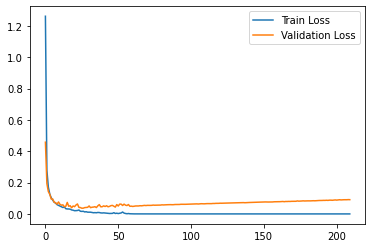

In [7]:
plt.plot(train_losses,label='Train Loss')
plt.plot(val_losses,label='Validation Loss') 
plt.legend()

In [8]:
model.load_state_dict(torch.load('model.pt'))
test_=np.array(test).reshape(-1,1,28,28)/255
testT=torch.tensor(test_)
test_dataset=testT.type(torch.FloatTensor)
test_loader=torch.utils.data.DataLoader(test_dataset,batch_size=val_batch_size,shuffle=False)
model=model.to(device)
with torch.no_grad():
        model.eval()
        label=[]
        for images in test_loader:
            images=images.to(device)
            #images=images.reshape(images[0],784)
            output=model(images)
            labels=torch.argmax(output,1)
            label+=labels
        
        sub={'ImageId':[i+1 for i in range(test.shape[0])],'Label':np.array(label)}
        submission=pd.DataFrame(sub)
        submission.to_csv('submissionpytorch1.csv',index=False)